In [1]:
# Import libraries
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
dataset_path = 'C:/Users/miros/Desktop/IT - Learning/Neural Networks, AI, Machine Learning/Datasets/sarcasm_headlines/Sarcasm_Headlines_Dataset.json'

In [4]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

datastore = list(parse_data(dataset_path))

In [5]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6681 - accuracy: 0.5849 - val_loss: 0.5914 - val_accuracy: 0.7384
Epoch 2/30
625/625 - 1s - loss: 0.4481 - accuracy: 0.8246 - val_loss: 0.3924 - val_accuracy: 0.8387
Epoch 3/30
625/625 - 1s - loss: 0.3201 - accuracy: 0.8745 - val_loss: 0.3549 - val_accuracy: 0.8524
Epoch 4/30
625/625 - 1s - loss: 0.2677 - accuracy: 0.8972 - val_loss: 0.3436 - val_accuracy: 0.8565
Epoch 5/30
625/625 - 1s - loss: 0.2308 - accuracy: 0.9126 - val_loss: 0.3415 - val_accuracy: 0.8548
Epoch 6/30
625/625 - 1s - loss: 0.2033 - accuracy: 0.9225 - val_loss: 0.3472 - val_accuracy: 0.8529
Epoch 7/30
625/625 - 1s - loss: 0.1818 - accuracy: 0.9316 - val_loss: 0.3644 - val_accuracy: 0.8538
Epoch 8/30
625/625 - 1s - loss: 0.1647 - accuracy: 0.9386 - val_loss: 0.3699 - val_accuracy: 0.8524
Epoch 9/30
625/625 - 1s - loss: 0.1482 - accuracy: 0.9471 - val_loss: 0.3831 - val_accuracy: 0.8530
Epoch 10/30
625/625 - 1s - loss: 0.1355 - accuracy: 0.9523 - val_loss: 0.4001 - val_accuracy: 0.8492

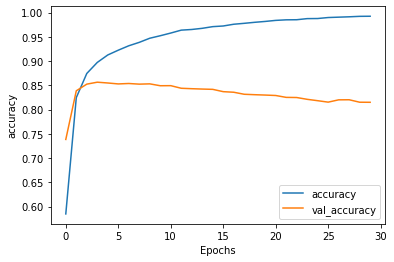

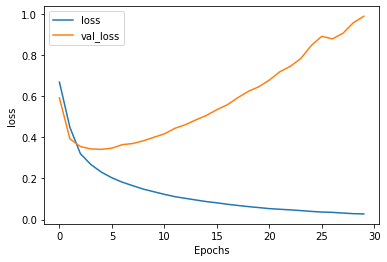

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]

In [14]:
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
print(model.predict(padded))

[[9.141086e-01]
 [2.088344e-05]]


In [16]:
results = model.predict(padded).round(2)

In [17]:
print(results) # closer to 1 is sarcastic, closer to 0 is not sarcastic

[[0.91]
 [0.  ]]


In [50]:
# Saving vecs.tsv and meta.tsv

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[0])
print(labels[0])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
former versace store clerk sues over secret 'black code' for minority shoppers
0


In [53]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [60]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()